### The structural error case

This code is to support the paper 'Active learning of model discrepancy with Bayesian experimental design'

This code recovers the Figs. 7, 8, 9.

In [1]:
import jax
import jax.numpy as jnp
import jax_cfd.base as cfd
import numpy as np
import functools
import copy
import pickle

from jax_cfd_test import my_equations
from jax_cfd_test import my_funcutils
from jax_cfd_test import my_forcing

from flax import linen as nn
from jax import random, numpy as jnp
from jax import grad

import optax

import time
import matplotlib.pyplot as plt

In [2]:
jax.devices()

[cuda(id=0)]

In [3]:
!pip show jax jaxlib

Name: jax
Version: 0.4.20
Summary: Differentiate, compile, and transform Numpy code.
Home-page: https://github.com/google/jax
Author: JAX team
Author-email: jax-dev@google.com
License: Apache-2.0
Location: /home/huchen/.local/lib/python3.10/site-packages
Requires: ml-dtypes, numpy, opt-einsum, scipy
Required-by: chex, equinox, flax, jax-cfd, jaxopt, lineax, optax, orbax-checkpoint, ott-jax, tree-math
---
Name: jaxlib
Version: 0.4.18+cuda12.cudnn89
Summary: XLA library for JAX
Home-page: https://github.com/google/jax
Author: JAX team
Author-email: jax-dev@google.com
License: Apache-2.0
Location: /home/huchen/.local/lib/python3.10/site-packages
Requires: ml-dtypes, numpy, scipy
Required-by: chex, jaxopt, optax, orbax-checkpoint


In [4]:
!pip show optax flax

Name: optax
Version: 0.2.2
Summary: A gradient processing and optimisation library in JAX.
Home-page: 
Author: 
Author-email: Google DeepMind <optax-dev@google.com>
License: 
Location: /home/huchen/.local/lib/python3.10/site-packages
Requires: absl-py, chex, jax, jaxlib, numpy
Required-by: flax
---
Name: flax
Version: 0.8.2
Summary: Flax: A neural network library for JAX designed for flexibility
Home-page: 
Author: 
Author-email: Flax team <flax-dev@google.com>
License: 
Location: /home/huchen/.local/lib/python3.10/site-packages
Requires: jax, msgpack, numpy, optax, orbax-checkpoint, PyYAML, rich, tensorstore, typing-extensions
Required-by: 


In [5]:
def sealed_convection_diffusion_true(measure_point_coordinate, center, stage):
    '''
    This function serves as the true system.

    inputs:
    -> measure_point_coordinate [float, (2,)]: measure location 
    -> center [float, (2,)]: true source location, which is the true value of the physical parameter 
    -> stage [int, ()]: time

    outputs:
    -> data_fin [float, (1,)]: point measurement at given measurement location and time
    -> data_array_at_last_step [float, (51,51)]: whole field data 
    '''
    grid = cfd.grids.Grid((size, size), domain=((lo_b, up_b), (lo_b, up_b)))

    bc = cfd.boundaries.neumann_boundary_conditions(2)
    
    grid_x = jnp.linspace(lo_b, up_b, size)
    grid_y = jnp.linspace(lo_b, up_b, size)
    xx, yy = jnp.meshgrid(grid_x, grid_y, indexing='ij')
    
    distance_array = 0.0*xx
    array = cfd.grids.GridArray(distance_array, offset=grid.cell_center, grid=grid)
    v0 = cfd.grids.GridVariable(array, bc)
    G=(v0,v0)

    time=0.0
    dt= 0.0005
    center_x= center[0]
    center_y= center[1]
    
    i = (measure_point_coordinate[0]-lo_b)/(up_b-lo_b)*(size-1)
    j = (measure_point_coordinate[1]-lo_b)/(up_b-lo_b)*(size-1)
    
    inner_steps = 1
    outer_steps = (stage+1)*100+1

    rollout_fn = jax.jit(my_funcutils.trajectory(my_equations.implicit_convection_diffusion5(
            density=density, viscosity=viscosity, dt=dt, grid=grid, forcing = my_forcing.exponential_force(grid,center_x=center_x, center_y=center_y)), outer_steps*inner_steps))
   

    last_step, _ = jax.device_get(rollout_fn(G,time))
    data_array_at_last_step = last_step[0][0].array.data
    
    data_fin=jax.scipy.ndimage.map_coordinates(data_array_at_last_step,[i,j],1)
    
    return data_fin, data_array_at_last_step
    
def sealed_convection_diffusion_nn(param, measure_point_coordinate, center, stage, model):
    '''
    This function serves as the forward model.

    inputs:
    -> params [dictionary]: the network parameters
    -> measure_point_coordinate [float, (2,)]: measure location 
    -> center [float, (2,)]: estimated source location, which is the estimated value of the physical parameter 
    -> stage [int, ()]: time
    -> model: network correction term

    outputs:
    -> data_fin [float, (1,)]: point measurement at given measurement location and time
    -> data_array_at_last_step [float, (51,51)]: whole field data 
    '''
    grid = cfd.grids.Grid((size, size), domain=((lo_b, up_b), (lo_b, up_b)))

    bc = cfd.boundaries.neumann_boundary_conditions(2)
    
    grid_x = jnp.linspace(lo_b, up_b, size)
    grid_y = jnp.linspace(lo_b, up_b, size)
    xx, yy = jnp.meshgrid(grid_x, grid_y, indexing='ij')
    
    distance_array = 0.0*xx
    array = cfd.grids.GridArray(distance_array, offset=grid.cell_center, grid=grid)
    v0 = cfd.grids.GridVariable(array, bc)
    G=(v0,v0)

    time=0.0
    dt= 0.0005
    center_x= center[0]
    center_y= center[1]
    
    i = (measure_point_coordinate[0]-lo_b)/(up_b-lo_b)*(size-1)
    j = (measure_point_coordinate[1]-lo_b)/(up_b-lo_b)*(size-1)
    
    inner_steps = 1
    outer_steps = (stage+1)*100+1

    rollout_fn = jax.jit(my_funcutils.trajectory(my_equations.implicit_convection_diffusion5(
            density=density, viscosity=viscosity, dt=dt, grid=grid, forcing = my_forcing.reciprocal_force_with_nn(grid,center_x=center_x, center_y=center_y,params=param,model =model)), outer_steps*inner_steps))
  
    last_step, _ = jax.device_get(rollout_fn(G,time))
    data_array_at_last_step = last_step[0][0].array.data
    
    data_fin=jax.scipy.ndimage.map_coordinates(data_array_at_last_step,[i,j],1)
    
    return data_fin, data_array_at_last_step
    

In [6]:
def log_normalize_pdf(log_probs):
    max_log_prob = jnp.max(log_probs)
    
    probs = jnp.exp(log_probs - max_log_prob)
    
    normalized_probs = probs / jnp.sum(probs)
    
    normalized_log_probs = jnp.log(normalized_probs+1e-32)
    
    return normalized_log_probs

def normalize_pdf(probs):
    return probs/jnp.sum(probs)

def calculate_loglikelihood(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, model):
    '''
    Inputs:
    -> stage: time
    -> center: true source location
    -> current_params: parameters of the network
    -> d_start: measurement point
    -> prior: prior information of the physical parameter
    -> noise_info: observation noise level
    -> num_d: None
    -> radio_d: None

    Outputs:
    -> loglikelihood (51,51)
    
    '''
    noise_loc, noise_base_scale, noise_ratio_scale = noise_info[0]
    output_point, _ = sealed_convection_diffusion_true(d_start, center, stage)
        
    observation = output_point + jnp.array([0.0])
    false_center = jnp.array([1.0,1.0]) - d_start
    false_start = jnp.array([0.5, 0.5])
    _, output_all = sealed_convection_diffusion_nn(current_params, false_start, false_center, stage, model)
    output_all_central_sym = jnp.fliplr(jnp.flipud(output_all))
    xb_lo = int((0.0 - lo_b) / (up_b - lo_b) * (size - 1))
    xb_up = int((1.0 - lo_b) / (up_b - lo_b) * (size - 1))
    output_for_xb = output_all_central_sym[xb_lo:(xb_up+1),xb_lo:(xb_up+1)]
    loglikelihood = jax.scipy.stats.norm.logpdf(observation, loc=output_for_xb, scale=noise_base_scale+noise_ratio_scale*jnp.abs(output_for_xb))
    return loglikelihood

def calculate_info_gain(prior, posterior):
    '''
    KL Divergence
    '''
    return jnp.sum(posterior*(jnp.log(posterior+1e-32) - jnp.log(prior+1e-32)))

def forward_posterior_infoGain(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, model):
    '''
    using forward model to update for posterior and calculate information gain
    '''
    loglikelihood = calculate_loglikelihood(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, model)
    log_evidence_list = log_normalize_pdf(loglikelihood) + jnp.log(prior+1e-32)
    evidence_list = jnp.exp(log_evidence_list)
    posterior = evidence_list/jnp.sum(evidence_list)
    KLD = calculate_info_gain(prior, posterior)
    return KLD, posterior


'''
main
'''


# PDE settings =================
size = 251                         # total points on one boundary of the PDE solving domain 
local_size = int((size-1)/5+1)     # points on one boundary of the interested PDE domain
density = 1.                       # constants in PDE
viscosity = 1                      # constants in PDE

lo_b = -2.                         # physical value of the lower bound of PDE solving domain
up_b = 3.                          # physical value of the upper bound of PDE solving domain



key = random.PRNGKey(0)  
x_for_shape = random.normal(key, (1, 2))  

class localFullyConnectedNN2(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=4)(x)  
        x = nn.tanh(x)
        x = nn.Dense(features=4)(x)  
        x = nn.tanh(x)
        x = nn.Dense(features=1)(x)  
        return x
        
model = localFullyConnectedNN2()  

params = {'params': {'Dense_0': {'bias': jnp.array([-0.5034, -0.0280, -0.3198,  0.4847]),
           'kernel': jnp.array([[ 4.8153,  4.1794,  8.2351,  9.6484],
        [-2.8456,  5.2352, -8.0220, -9.1204]])},
          'Dense_1': {'bias': jnp.array([-0.4493,  1.2653,  1.2336,  0.4221]),
           'kernel': jnp.array([[-0.7218,  2.8800,  3.2308,  1.1351],
        [-5.0888,  4.8622,  4.7844,  5.0217],
        [-2.9412,  3.9048, -4.2149, -5.2085],
        [ 4.3755, -3.2684,  4.4775,  3.3922]])},
          'Dense_2': {'bias': jnp.array([-0.3442]),
           'kernel': jnp.array([[-10.5900],
        [ 10.0693],
        [-10.0099],
        [-10.6412]])}}
         }


params_back = copy.deepcopy(params)

# BED settings =================
n_stage = 5                               # total number of time stages
d_start = jnp.array([0.5,0.5])            # initial point of design optimization
center = jnp.array([0.25,0.25])           # true source location

d_change_range = jnp.array([0.2,0.2])

noise_loc = 0                             # zero mean Gaussian noise
noise_base_scale = 0.05                   # std of Gaussian noise
noise_ratio_scale = 0.05                  # relative std of Gaussian noise
noise_info = [(noise_loc, noise_base_scale, noise_ratio_scale),]

num_d = 1.0                               # None use parameter
radio_d = 0.5                             # None use parameter

xb_size = int((size - 1)/5+1)
prior_ori = jnp.ones((xb_size,xb_size))
prior = prior_ori/jnp.sum(prior_ori)      # initial uniform prior on a 51*51 mesh

key = random.split(key,int(n_stage*2+1))

    
def loss_param_refine5(current_params, d_start, stage, estimated_center, model, observation):
    '''
    loss function to update the network parameter

    Inputs:
    -> current_params: network parameter
    -> d_start: measure location
    -> stage: time
    -> estimated_center: estimated source location, the MAP point. defined in Eq.(8) and Eq.(11) in the paper
    -> model: network
    -> observation: given measurement

    Outputs:
    -> -loglikelihood: the log likelihood of the current model to produce measured data
    '''
    y_f, _ = sealed_convection_diffusion_nn(current_params, d_start, estimated_center, stage, model)
    loglikelihood = jax.scipy.stats.norm.logpdf(observation, loc=y_f, scale=noise_base_scale+noise_ratio_scale* jnp.abs(y_f))

    return -loglikelihood


def loss_design(d_start, current_params, stage, center, prior, noise_info, num_d, radio_d, key, model):
    KLD, _ = forward_posterior_infoGain(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, model)
    return -KLD


iteration_step_number1 = tuple((50,45,40,40,40,40,40,40,40,40,40,40,40,30,20))    # the iteration numbers for design optimization of each stage
iteration_step_number2 = tuple((10,80,80,80,80,80,80,80,80,80,80,80,80,80,100))   # the iteration numbers for network parameter updating of each stage
stage_to_skip = [0]   # skip the model correction for given stages


learning_rate1 = 0.003                           # learning rate of design optimization 
learning_rate2 = jnp.ones(n_stage)*0.012         # learning rate of model correction

print('Network Settings: \n')
print(f'learning_rate1 = ', learning_rate1)
print(f'learning_rate2 = ', learning_rate2)
print(f'iteration_step_number1 = ', iteration_step_number1)
print(f'iteration_step_number2 = ', iteration_step_number2)


# lists to store data

KLD_list=[]                       # the KL divergence of each design optimization iteration
evidence_list=[]                  # the loss function value of each model correction iteration
params_list=[]                    # the updated network parameter at each stage
design_list = []                  # the updated design at each stage
design_list.append(d_start)
posterior_list = []               # the updated posterior with corrected model at each stage
posterior_oed_list = []           # the updated posterior with uncorrected model at each stage
estimated_posterior_point = []    # the estimated center at each stage

Network Settings: 

learning_rate1 =  0.003
learning_rate2 =  [0.012 0.012 0.012 0.012 0.012]
iteration_step_number1 =  (50, 45, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 30, 20)
iteration_step_number2 =  (10, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 100)



 stage =  0 

stage = 0, only run forward model and update posterior
start learning design
start design :  [0.5 0.5]
Execution learning design time: 90.31517958641052 seconds
design from OED is [0.33546886 0.33540025]
estimated_center is  [0.268 0.384]
design for model correction is [0.33546886 0.33540025]
measurement is: 0.37959447503089905
start learning params
stage 0 dont learn error parameters
Execution learning param time: 0.947113037109375 seconds

 stage =  1 

start learning design
start design :  [0.33546886 0.33540025]
Execution learning design time: 82.77893447875977 seconds
design from OED is [0.21560374 0.21535774]
estimated_center is  [0.24399999 0.212     ]
design for model correction is [0.21560374 0.21535774]
measurement is: 0.489087849855423
start learning params
Execution learning param time: 115.96331930160522 seconds

 stage =  2 

start learning design
start design :  [0.21560374 0.21535774]
Execution learning design time: 76.09065103530884 seconds
design from O

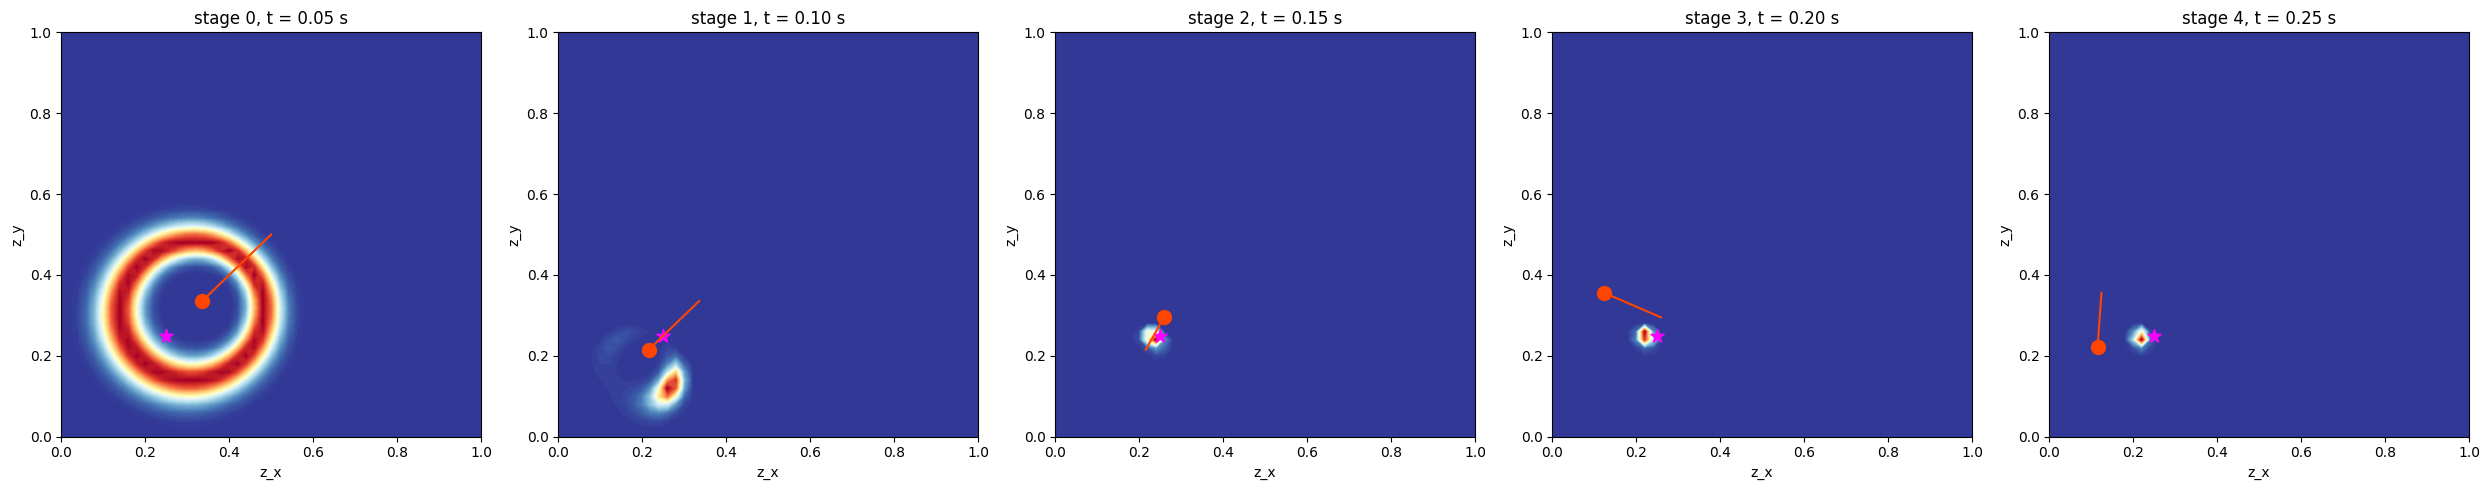

In [7]:
fig, axes = plt.subplots(1, n_stage, figsize=(5*n_stage, 5))
grid_x_plot0, grid_y_plot0 = np.meshgrid(np.linspace(0, 1, local_size), np.linspace(0, 1, local_size))

for stage in range(n_stage):
        
    print('\n stage = ', stage, '\n')
    key_for_design = random.split(key[stage*2],iteration_step_number1[stage])   # set keys
    key_for_param = random.split(key[stage*2+1],iteration_step_number2[stage])  # set keys
    
    clip_count = 0 # count for meeting design search bound
    
    if stage!=0:
        del tx1
    else:
        print(f'stage = 0, only run forward model and update posterior')
        
    tx1 = optax.chain(
    optax.adam(learning_rate1),
    optax.add_decayed_weights(1e-4) 
    )  # initilize optimizer for design optimization
    
    opt_state1 = tx1.init(d_start)  # initilize optimizer state for design optimization
    
    d_limit_min = d_start - d_change_range # setup design searching bound
    d_limit_max = d_start + d_change_range # setup design searching bound
    
    start_time = time.time()
    d_start_backup = d_start

    print('start learning design')
    print(f'start design : ', d_start)
    for i in range(iteration_step_number1[stage]):
        negtive_KLD, grad_design = jax.value_and_grad(loss_design)(d_start, params, stage, center, prior, noise_info, num_d, radio_d, key_for_design[i], model) # loss function
        updates, opt_state1 = tx1.update(grad_design, opt_state1, params=d_start) # track design updates

        
        # in case of Nan
        oed_nan_index = 0
        updates_contain_nans = any(jnp.any(jnp.isnan(u)) for u in jax.tree_util.tree_leaves(updates))
        if updates_contain_nans:
            oed_nan_index = oed_nan_index + 1
            print(f'NaN appears in learning. Perturb params and continue. Nan count: {oed_nan_index}')
            noise = 0.05*jax.random.normal(key_for_design[i], d_start.shape)
            d_start = d_start+ noise
        else:
            oed_nan_index = 0
            d_start = optax.apply_updates(d_start, updates)
    
        d_start_before_clip = d_start   # clip the design if it exceeds the searching bound
        d_start = jnp.clip(d_start, d_limit_min, d_limit_max)
        
        # if design is clipped, count +1
        clip_count = 0
        if not jnp.all(d_start == d_start_before_clip):
            clip_count += 1
        else:
            clip_count = 0

        if clip_count >= 5:
            print(f"Stopping iteration at step {i} as clip function has been activated 5 times.")
            break
        
        if np.isnan(d_start).any() or np.isnan(negtive_KLD).any():
            print('some results are Nan')
            break
    
        KLD_list.append(-negtive_KLD)
        
        if oed_nan_index > 6:
            print('Continue Nan and perturbed for 6 times，stop BED')
            break
            
            
    end_time = time.time()
    print(f"Execution learning design time: {end_time - start_time} seconds")
    print(f'design from OED is {d_start}')

    # update posterior with the uncorrected model
    _, posterior = forward_posterior_infoGain(params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], model)
    del prior
    prior = posterior
    posterior_oed_list.append(posterior)

    design_list.append(d_start)
    
    if stage!=0:
        del tx2
        del opt_state2
        
    tx2 = optax.adam(learning_rate2[stage])  # initilize optimizer for model correction
    
    opt_state2 = tx2.init(params)  # initilize optimizer state for model correction

    start_time = time.time()

    # calculate the MAP estimate of the physical parameter following Eq. (11)
    num_top = 5
    indices = jnp.argpartition(posterior.ravel(), -num_top)[-num_top:]
    multi_indices = jnp.unravel_index(indices, posterior.shape)
    average_x = np.mean(multi_indices[0])
    average_y = np.mean(multi_indices[1])
    estimated_center = jnp.array([average_x, average_y])/50
    print(f'estimated_center is ', estimated_center)
    estimated_posterior_point.append(estimated_center)
        

    if stage == 2:
        print('Use a better design at stage 2.')
        d_start = d_start + jnp.array([0.05,-0.05])
        # for a more rigorous method to calculate a better design, please refer to our latest work: 
        # 'Bayesian Experimental Design for Model Discrepancy Calibration: An Auto-Differentiable Ensemble Kalman Inversion Approach'

    
    print(f'design for model correction is {d_start}')
    observation, _ = sealed_convection_diffusion_true(d_start, center, stage) # use the optimized design to acquire data
    print(f'measurement is: {observation}')

    print('start learning params')
    for i in range(iteration_step_number2[stage]):
        if stage in stage_to_skip:
            print(f'stage {stage} dont learn error parameters')
            break
        
        estimated_center_perturbed = estimated_center + 0.05 * jax.random.normal(key_for_param[i], estimated_center.shape)*jnp.exp(-0.04*i)  # perturb estimated center
        max_evidence_items, grad_params = jax.value_and_grad(loss_param_refine5)(params, d_start, stage, estimated_center_perturbed, model, observation) # loss function for model correction

        clip_norm = 1e10       # fix the extreme gradient
        clip_transform = optax.clip_by_global_norm(clip_norm)
        clipped_grads, _ = clip_transform.update(grad_params, state=None)
        
        updates, opt_state2 = tx2.update(clipped_grads, opt_state2, params=params)  # network updates
        
        # in case of Nan
        updates_contain_nans = any(jnp.any(jnp.isnan(u)) for u in jax.tree_util.tree_leaves(updates))
        if updates_contain_nans:
            print('NaN appears in learning. Perturb params and continue.')
            noise = jax.tree_util.tree_map(lambda p: 0.01 * jax.random.normal(key_for_param[i], p.shape), params)
            params = jax.tree_util.tree_map(lambda p, n: p + n, params, noise)
        else:
            params = optax.apply_updates(params, updates)
        
        if np.isnan((max_evidence_items)).any():
            print('some results are Nan')
            break
            
        evidence_list.append(-max_evidence_items)

        
    params_list.append(params)
    
    end_time = time.time()
    print(f"Execution learning param time: {end_time - start_time} seconds")

    # update posterior with corrected model
    if stage not in stage_to_skip:
        _, posterior = forward_posterior_infoGain(params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], model)
        if stage!=0:
             del prior
        prior = posterior
        
    posterior_list.append(posterior)

    
    # reset the design to the original trajectory
    d_start = design_list[-1]
        
    
    axes[stage].contourf(grid_x_plot0, grid_y_plot0, posterior.T, levels=100,cmap='RdYlBu_r' )
    axes[stage].scatter(d_start[0], d_start[1], marker='o', s=100, c='orangered')
    axes[stage].scatter(center[0], center[1], marker='*', s=100, c='magenta')
    axes[stage].plot([d_start[0],d_start_backup[0]],
                    [d_start[1],d_start_backup[1]], c='orangered')
    axes[stage].set_title(f'stage {stage}, t = {((stage+1)*0.05):.2f} s')
    axes[stage].set_xlabel('z_x')
    axes[stage].set_ylabel('z_y')



plt.tight_layout()
plt.show()

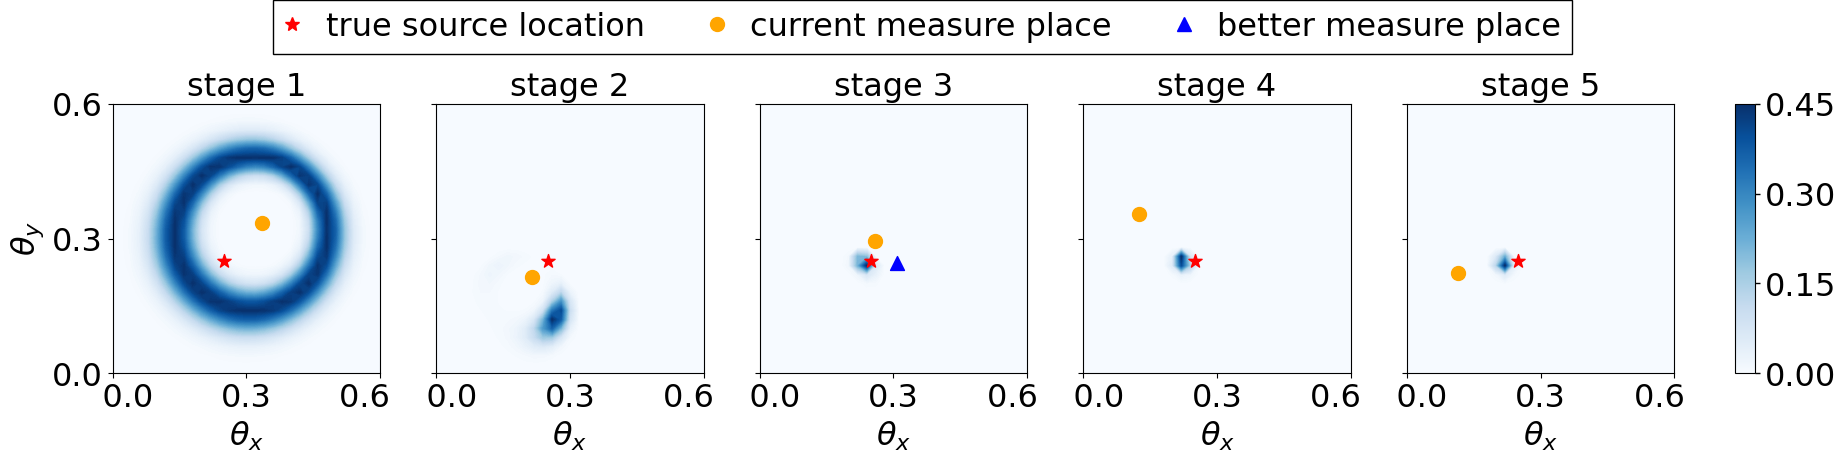

In [9]:
import numpy as np
import jax.numpy as jnp


n_stage =5
local_size = 51
center = jnp.array([0.25,0.25])

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib.colors import LinearSegmentedColormap

fig, axes = plt.subplots(1, 5, figsize=(4.03*5, 3.5))
fig.subplots_adjust(wspace=0.21)

grid_x_plot0, grid_y_plot0 = np.meshgrid(np.linspace(0, 1, local_size), np.linspace(0, 1, local_size))

        
fontsize = 23
pic_num=0

# 内置颜色图
cmap = 'Blues'
star_color = 'r'


def custom_formatter(x, pos):
    if x == 0.0:
        return '   0.0' 
    elif x == 0.6:
        return '0.6   ' 
    elif x == 0.3:
        return '0.3'
    else:
        return f'{x:.2f}'


for stage in [0,1,2,3,4]:
    d_start = design_list[stage+1]
    d_start_backup = design_list[stage]
    contour=axes[pic_num].contourf(grid_x_plot0, grid_y_plot0, posterior_list[stage].T, levels=100,cmap=cmap)#plasma' )
    axes[pic_num].scatter(d_start[0], d_start[1], marker='o', s=100, c='orange')

    if stage == 2:
        axes[pic_num].scatter(d_start[0]+0.05, d_start[1]-0.05, marker='^', s=100, c='blue')
    
    axes[pic_num].scatter(center[0], center[1], marker='*', s=100, c=star_color)
    axes[pic_num].set_title(f'stage {stage+1}', fontsize=fontsize)  
    axes[pic_num].set_xlabel('$\\theta_x$', fontsize=fontsize)  
    axes[pic_num].set_yticks([0.0, 0.3,0.6])
    if stage == 0:
        axes[pic_num].set_ylabel('$\\theta_y$', fontsize=fontsize)  
    else:
        axes[pic_num].set_yticklabels([]) 
        
    axes[pic_num].tick_params(axis='both', which='major', labelsize=fontsize)
    axes[pic_num].set_xticks([0.0,0.3,0.6])
    axes[pic_num].xaxis.set_major_formatter(FuncFormatter(custom_formatter))
    axes[pic_num].set_xlim([0.0,0.6])
    axes[pic_num].set_ylim([0.0,0.6])
    pic_num=pic_num+1

cbar_ax = fig.add_axes([0.93, 0.11, 0.01, 0.77]) 
contour_set = plt.cm.ScalarMappable(cmap=cmap)#'plasma')
contour_set.set_array(posterior_list[stage])

contour_set.set_clim(0, 0.45)
ticks = [0, 0.15, 0.30, 0.45]

cbar = fig.colorbar(contour_set, cax=cbar_ax, orientation='vertical', shrink=0.4, aspect=20, pad=0.06)
cbar.ax.tick_params(labelsize=fontsize, width=1)
cbar.set_ticks(ticks)
cbar.update_ticks()

plt.plot([], [], marker='*', markersize=10, color=star_color, linestyle='None', label='true source location')
plt.plot([], [], marker='o', markersize=10, color='orange', linestyle='None', label='current measure place')

plt.plot([], [], marker='^', markersize=10, color='b', linestyle='None', label='better measure place')

legend = plt.legend(
    loc='center',
    bbox_to_anchor=(0.527, 1.1),
    ncol=3,
    frameon=True,
    framealpha=1,
    edgecolor='black',
    fontsize=fontsize,
    borderpad=0.05, handlelength=0.5,
    bbox_transform=fig.transFigure  
)
legend.get_frame().set_edgecolor('black') 
legend.get_frame().set_linewidth(1) 
legend.get_frame().set_boxstyle("Square")


#plt.savefig('NN case good design.png',bbox_inches='tight')

In [6]:
# save data
import pickle

numpy_list = [np.array(arr) for arr in posterior_list]
data_to_save = {
    "posterior_list": numpy_list,
    "posterior_oed_list": posterior_oed_list,
    "design_list": design_list,
    "params_list": params_list,
    "estimated_posterior_point": estimated_posterior_point
}

with open('all_data_nn_case_data_6_test11.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

In [16]:
# read data
with open('all_data_nn_case_data_6_test11.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

posterior_list = loaded_data["posterior_list"]
posterior_oed_list = loaded_data["posterior_oed_list"]
design_list = loaded_data["design_list"]
params_list = loaded_data["params_list"]
estimated_posterior_point = loaded_data["estimated_posterior_point"]

In [11]:
def show_nn_trajectory(params_list, apply_model, colormap = 'Blues', center_x=0, center_y=0, size=85):
    '''
    function to plot Fig. 8, panel (a)
    '''
    x = jnp.linspace(0, 0.3, size).reshape(-1, 1)
    y = jnp.linspace(0, 0.3, size).reshape(-1, 1)
    xy_combined = jnp.concatenate((x, y), axis=1)
    
    exponent_internal = ((x - center_x) ** 2 + (y - center_y) ** 2)
    factor = 2.0 / (2.0 * jnp.pi * 0.05 ** 2)
    array_exponent = factor * jnp.exp(-exponent_internal / (2.0 * 0.05 ** 2))
    array_reciprocal = factor * 1.5 / (exponent_internal ** 2 / (2.0 * 0.05 ** 2) ** 2 + 1.0)
    
    plt.figure(figsize=(10, 5))
    
    cmap = plt.colormaps[colormap].resampled(len(params_list)+2)#cm.get_cmap('Blues', len(params_list))
    for index, params in enumerate(params_list):
        #if index not in [6]:
        #    continue
        array_nn = apply_model.apply(params, xy_combined) #* 100.0
        
        plt.plot(jnp.sqrt(2) * x.squeeze(), 
                 (array_nn.squeeze() + array_reciprocal.squeeze()), 
                 label=f'NN + Reciprocal - Params {index+1}',
                 color=cmap(index+1))
    
    plt.plot(jnp.sqrt(2) * x.squeeze(), 
             array_exponent.squeeze(), color='r', linestyle = '--', label='Exponent')
    plt.plot(jnp.sqrt(2) * x.squeeze(), 
             array_reciprocal.squeeze(), color='g', label='Reciprocal')
    
    plt.ylabel('values of model')
    plt.xlabel('Inputs')
    

# EKI

The ensemble-based indicator to evaluate information gain. For more rigorous discussion about this method, please refer to

'Bayesian Experimental Design for Model Discrepancy Calibration: An Auto-Differentiable Ensemble Kalman Inversion Approach'

In [9]:
import os
import pickle
import re
import gc
from flax.traverse_util import flatten_dict, unflatten_dict

def reconstruct_array_to_dict(params_grad_array, grads):
    """
    Reconstruct a dictionary from the flattened array

    Inputs:
    - params_grad_array: flattened array
    - grads: initial parameter dictionary, which mainly provides the dictionary structure.

    Outputs:
    - reconstructed_grads: reconstructed parameter dictionary
    """
    params_grad_flat = flatten_dict(grads)
    shapes = {k: v.shape for k, v in params_grad_flat.items()}

    index = 0
    reconstructed_params_grad_flat = {}
    for k, shape in shapes.items():
        size = size = int(np.prod(shape)) 
        reconstructed_params_grad_flat[k] = jnp.reshape(params_grad_array[index:index+size], shape)
        index += size

    reconstructed_grads = unflatten_dict(reconstructed_params_grad_flat)

    return reconstructed_grads

def reconstruct_dict_to_array(grads):
    """
    Flatten the dictionary into a one-dimensional array

    Inputs:
    - grads: dictionary

    Outputs:
    - params_grad_array: flattened array
    """
    params_grad_flat = flatten_dict(grads)
    
    flat_arrays = [jnp.ravel(v) for v in params_grad_flat.values()]
    
    params_grad_array = jnp.concatenate(flat_arrays)
    
    return params_grad_array
    
def kl_divergence(mu1, sigma1, mu2, sigma2):
    '''
    KL divergence between two Gaussian distributions
    '''
    sigma2_inv = jnp.linalg.inv(sigma2)
    
    term1 = jnp.trace(sigma2_inv @ sigma1)
    term2 = (mu2 - mu1).T @ sigma2_inv @ (mu2 - mu1)
    
    _, logdet_sigma1 = jnp.linalg.slogdet(sigma1)
    _, logdet_sigma2 = jnp.linalg.slogdet(sigma2)
    term3 = logdet_sigma2 - logdet_sigma1
    
    kl_div = 0.5 * (term1 + term2 - len(mu1) + term3)
    
    return kl_div
    


def insert_from_u(u,indexs):
    '''
    plug the corresponding data from a given matrix
    
    Inputs:
    - u: given matrix
    - indexs: coordinates to extract data
    
    '''
    y_f_member = jnp.zeros((1, len(indexs)))
    for i in range(len(indexs)):
        y_f = jax.scipy.ndimage.map_coordinates(u,indexs[i],1)
        y_f_member = y_f_member.at[0,i].set(y_f)

    return y_f_member


def generate_2d_grid_xy(x_mid, y_mid, space, num=3):
    '''
    Create the index of several points near the given point
    '''
    
    if num % 2 == 0:
        raise ValueError("num must be odd")

    x = np.linspace(x_mid - space * (num // 2), x_mid + space * (num // 2), num)
    
    y = np.linspace(y_mid - space * (num // 2), y_mid + space * (num // 2), num)
    
    X, Y = np.meshgrid(x, y)
    
    grid_points = np.vstack([X.ravel(), Y.ravel()]).T
    
    return grid_points
    

In [6]:
def generate_sample(key, mean, std_dev):
    return mean + std_dev * jax.random.normal(key, shape=mean.shape)
    
def natural_key(filename):
    return [int(part) if part.isdigit() else part for part in re.split(r'(\d+)', filename)]

def save_checkpoint(i, j, params_trajectory, ensemble_members_array):
    checkpoint = {
        'i': i,
        'j': j,
        'params_trajectory': params_trajectory,
        'ensemble_members_array': ensemble_members_array
    }
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_i_{i}_j_{j}.pkl')
    with open(checkpoint_path, 'wb') as f:
        pickle.dump(checkpoint, f)
    print(f"Checkpoint saved at i={i}, j={j}")

def load_checkpoint(j):
    checkpoint_files = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith(f'_j_{j}.pkl')], key=natural_key)
    if checkpoint_files:
        latest_checkpoint = checkpoint_files[-1]
        checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)
        with open(checkpoint_path, 'rb') as f:
            checkpoint = pickle.load(f)
        print(f"Checkpoint loaded from {latest_checkpoint}")
        return checkpoint
    return None

def EnKF_process_multidata(indexs, observation, ensemble_member, estimated_center, stage, model, key2, step_index, num_top=5):
    
    ensemble_size_local = ensemble_member.shape[0]
    noise_loc, noise_base_scale, noise_ratio_scale = noise_info[0]

    observe_size = len(indexs)
    y_fs = jnp.zeros((ensemble_size_local,observe_size))

    # vmap forward
    batch_size = 20

    # single-member prediction
    def process_one(member):
        member_dict = reconstruct_array_to_dict(member, params)
        _, u = sealed_convection_diffusion_nn(member_dict,
                                              d_start,
                                              estimated_center,
                                              stage,
                                              model)   # u.shape == (251, 251)
        y = insert_from_u(u, indexs).squeeze()  # shape == (observe_size,)
        return y

    # vectorize over a batch of members
    process_batch = jax.vmap(process_one, in_axes=0)

    # compute in batches of 50, serially accumulating into y_fs
    for start in range(0, ensemble_size_local, batch_size):
        end = min(start + batch_size, ensemble_size_local)
        batch = ensemble_member[start:end]         # shape (<=50, param_dim)
        y_batch = process_batch(batch)            # shape (<=50, observe_size)
        y_fs = y_fs.at[start:end, :].set(y_batch)
        print('.', end='')
        
    
    y_f_mean = np.mean(y_fs, axis=0).reshape(1,-1)
    
    noise_covariance_matrix = np.eye(observe_size) * noise_base_scale
    P_yy = 1/(ensemble_size_local - 1) * np.matmul((y_fs - y_f_mean).T, (y_fs - y_f_mean)) + noise_covariance_matrix

    x_f_theta = ensemble_member
    x_f_mean = jnp.mean(x_f_theta, axis=0).reshape(1,-1)

    x_f_deviation = x_f_theta - x_f_mean
    y_f_deviation = y_fs - y_f_mean
    P_xy = jnp.matmul(x_f_deviation.T, y_f_deviation) / (ensemble_size_local - 1) 

    K = np.matmul(P_xy, np.linalg.inv(P_yy))

    x_a = x_f_theta + jnp.matmul(K, (observation - y_fs).T).T

    
    return x_a


with open('all_data_nn_case_data_6_test9.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

posterior_list = loaded_data["posterior_list"]
design_list = loaded_data["design_list"]
params_list = loaded_data["params_list"]
estimated_posterior_point = loaded_data["estimated_posterior_point"]


stage = 2
ensemble_size = 300
ensemble_step = 10


std_dev = 0.3  # std for the Gaussian distribution added to network parameters

key_ensemble = jax.random.PRNGKey(0)  # 随机数种子
keys_ensemble = jax.random.split(key_ensemble, ensemble_size)
key2 = jax.random.PRNGKey(2)  # 随机数种子

class localFullyConnectedNN2(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=4)(x)
        x = nn.tanh(x)  # 激活函数
        x = nn.Dense(features=4)(x)
        x = nn.tanh(x)  # 激活函数
        x = nn.Dense(features=1)(x)
        return x
        
model2 = localFullyConnectedNN2()



estimated_center = estimated_posterior_point[stage]
print(f'estimated center is {estimated_center}')



noise_loc = 0
noise_base_scale = 0.005
noise_ratio_scale = 0.05
noise_info = [(noise_loc, noise_base_scale, noise_ratio_scale),]



checkpoint_dir = './checkpoints/nn_case_data_6_EnFK_stage2_test21'
os.makedirs(checkpoint_dir, exist_ok=True)

d_start1 = design_list[stage+1]
d_start2 = design_list[stage+1]+jnp.array([0.05,-0.05])

# main
for j in [0,1]:

    params = params_list[stage-1]
    
    mean_array = reconstruct_dict_to_array(params)

    ensemble_length=len(mean_array)

    if j == 0:
        d_start = d_start1
    elif j == 1:
        d_start = d_start2
    

    indexs = generate_2d_grid_xy(d_start[0]*50+100, d_start[1]*50+100, 1)
        
    # generate data
    _, ut  = sealed_convection_diffusion_true(d_start, center, stage) 
    observations = insert_from_u(ut,indexs)
    _, u0  = sealed_convection_diffusion_true(d_start, estimated_center, stage) 
    y0 = insert_from_u(u0,indexs)
     
        
    checkpoint = load_checkpoint(j)
    
    if checkpoint is not None:
        start_step = checkpoint['i']
        params_trajectory = checkpoint['params_trajectory']
        ensemble_members_array = checkpoint['ensemble_members_array']
        print(f'continue from design {j}, step {i}')
    else:
        start_step = 0
        ensemble_members_array = jax.vmap(generate_sample, in_axes=(0, None, None))(keys_ensemble, mean_array, std_dev)
        params_trajectory = np.zeros((ensemble_step + 1, ensemble_size, ensemble_length))
        params_trajectory[0] = ensemble_members_array
        print(f'start from design {j}. step initial')



    for i in range(start_step, ensemble_step):
        key2 = jax.random.split(key2,1)[0]
        
        ensemble_members_array = EnKF_process_multidata(indexs, observations, ensemble_members_array, estimated_center, stage, model2, key2, i, num_top=5)
        params_trajectory[i + 1] = ensemble_members_array
        print('|', end='')

        if (i + 1) % 5 == 0:
            save_checkpoint(i + 1, j, params_trajectory, ensemble_members_array)
    
    save_checkpoint(ensemble_step, j, params_trajectory, ensemble_members_array)
    print('-', end='')

    if j == 0:
        params_trajectory_good_design = params_trajectory
    elif j == 1:
        params_trajectory_bad_design = params_trajectory

print('saved in ', checkpoint_dir)

estimated center is [0.236      0.24800001]
start from design 0. step initial
...............|...............|...............|...............|...............|Checkpoint saved at i=5, j=0
...............|...............|...............|...............|...............|Checkpoint saved at i=10, j=0
Checkpoint saved at i=10, j=0
-start from design 1. step initial
...............|...............|...............|...............|...............|Checkpoint saved at i=5, j=1
...............|...............|...............|...............|...............|Checkpoint saved at i=10, j=1
Checkpoint saved at i=10, j=1
-saved in  ./checkpoints/nn_case_data_6_EnFK_stage2_test21


Checkpoint data loaded successfully.
Checkpoint data loaded successfully.


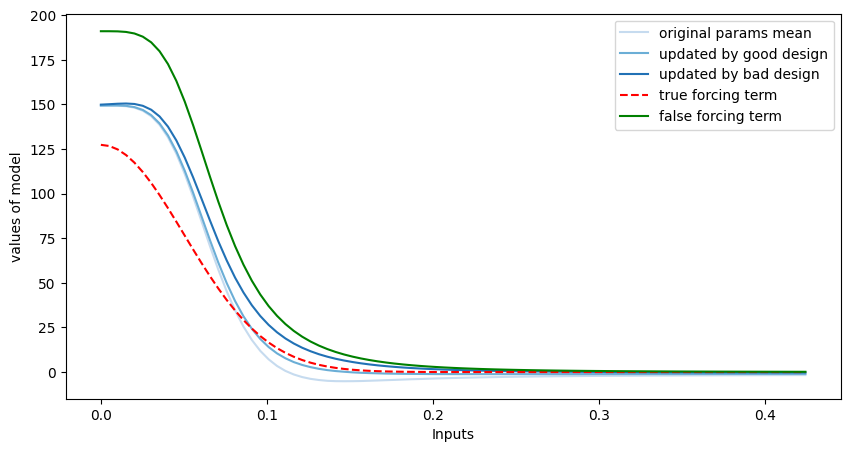

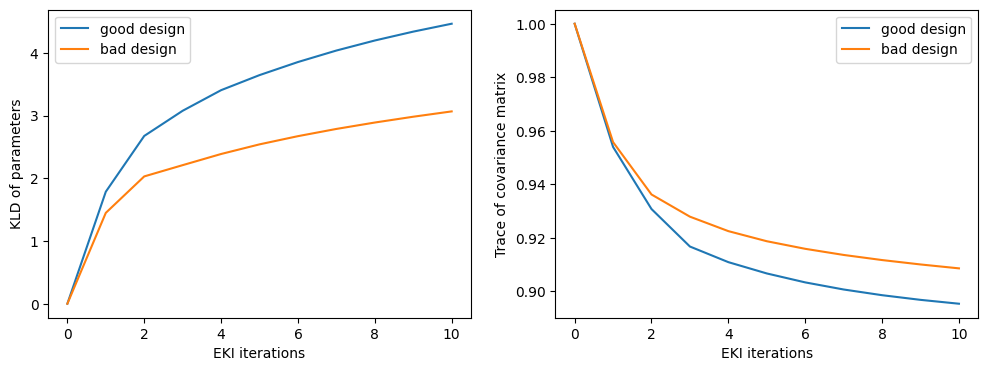

In [13]:
stage = 2
ensemble_step = 10
ensemble_size = 300

checkpoint_file_path = './checkpoints/nn_case_data_6_EnFK_stage2_test21/checkpoint_i_10_j_0.pkl'

if os.path.exists(checkpoint_file_path):
    with open(checkpoint_file_path, 'rb') as f:
        checkpoint_data = pickle.load(f)
    print("Checkpoint data loaded successfully.")
else:
    print("Checkpoint file not found.")

result_matrix_design_7 = checkpoint_data['params_trajectory'] # bad



checkpoint_file_path = './checkpoints/nn_case_data_6_EnFK_stage2_test21/checkpoint_i_10_j_1.pkl' 

if os.path.exists(checkpoint_file_path):
    with open(checkpoint_file_path, 'rb') as f:
        checkpoint_data = pickle.load(f)
    print("Checkpoint data loaded successfully.")
else:
    print("Checkpoint file not found.")

result_matrix_design_5 = checkpoint_data['params_trajectory'] # good



params0 = reconstruct_array_to_dict(np.mean(result_matrix_design_5[0], axis=0),params)
params5 = reconstruct_array_to_dict(np.mean(result_matrix_design_5[-1], axis=0),params)
params7 = reconstruct_array_to_dict(np.mean(result_matrix_design_7[-1], axis=0),params)
show_nn_trajectory([params0,params5, params7], model, 'Blues', center_x=0, center_y=0, size=85)
plt.legend()

leg = plt.gca().get_legend()

new_labels = ['original params mean', 'updated by good design', 'updated by bad design', 'true forcing term', 'false forcing term']

for text, new_label in zip(leg.get_texts(), new_labels):
    text.set_text(new_label)

plt.draw()


u_t = sealed_convection_diffusion_true(d_start, center, stage)[1][100:151,100:151]
u_design_5 = sealed_convection_diffusion_nn(params5, d_start, center, stage, model)[1][100:151,100:151]
u_design_7 = sealed_convection_diffusion_nn(params7, d_start, center, stage, model)[1][100:151,100:151]
#print(np.sum((u_t - u_design_5)**2),np.sum((u_t - u_design_7)**2))


mean_ori = np.mean(result_matrix_design_5[0],axis=0)
mean_ori_centered = result_matrix_design_5[0] - mean_ori
var_ori = np.cov(mean_ori_centered, rowvar=False)
kld_trajectory5 = np.zeros(ensemble_step+1)
kld_trajectory5[0] = kl_divergence(mean_ori, var_ori, mean_ori, var_ori)
kld_compare_to_before5 = np.zeros(ensemble_step)
mean_current_back = mean_ori
var_current_back = var_ori
covar_trace_5 = np.zeros(ensemble_step+1)
covar_trace_5[0] = np.trace(var_ori)
covar_det_5 = np.zeros(ensemble_step+1)
covar_det_5[0] = np.linalg.det(var_ori)

for i in range(1,ensemble_step+1):
    mean_current = np.mean(result_matrix_design_5[i],axis=0)
    mean_current_centered = result_matrix_design_5[i] - mean_current
    var_current = np.cov(mean_current_centered, rowvar=False)
    kld_trajectory5[i]=kl_divergence(mean_current, var_current, mean_ori, var_ori)
    kld_compare_to_before5[i-1]=kl_divergence(mean_current, var_current, mean_current_back, var_current_back)
    covar_trace_5[i] = np.trace(var_current)
    covar_det_5[i] = np.linalg.det(var_current)
    mean_current_back = mean_current
    var_current_back = var_current 


mean_ori = np.mean(result_matrix_design_7[0],axis=0)
mean_ori_centered = result_matrix_design_7[0] - mean_ori
var_ori = np.cov(mean_ori_centered, rowvar=False)
kld_trajectory7 = np.zeros(ensemble_step+1)
kld_trajectory7[0] = kl_divergence(mean_ori, var_ori, mean_ori, var_ori)
kld_compare_to_before7 = np.zeros(ensemble_step)
mean_current_back = mean_ori
var_current_back = var_ori
covar_trace_7 = np.zeros(ensemble_step+1)
covar_trace_7[0] = np.trace(var_ori)
covar_det_7 = np.zeros(ensemble_step+1)
covar_det_7[0] = np.linalg.det(var_ori)

for i in range(1,ensemble_step+1):
    mean_current = np.mean(result_matrix_design_7[i],axis=0)
    mean_current_centered = result_matrix_design_7[i] - mean_current
    var_current = np.cov(mean_current_centered, rowvar=False)
    kld_trajectory7[i]=kl_divergence(mean_current, var_current, mean_ori, var_ori)
    kld_compare_to_before7[i-1]=kl_divergence(mean_current, var_current, mean_current_back, var_current_back)
    covar_trace_7[i] = np.trace(var_current)
    covar_det_7[i] = np.linalg.det(var_current)
    mean_current_back = mean_current
    var_current_back = var_current 


fig, axes = plt.subplots(1,2,figsize=(12,4))

axes[0].plot(kld_trajectory5, label = 'good design')
axes[0].plot(kld_trajectory7, label = 'bad design')
axes[0].set_xlabel('EKI iterations')
axes[0].set_ylabel('KLD of parameters')
axes[0].legend()


axes[1].plot(covar_trace_5/covar_trace_5[0], label = 'good design')
axes[1].plot(covar_trace_7/covar_trace_7[0], label = 'bad design')
axes[1].set_xlabel('EKI iterations')
axes[1].set_ylabel('Trace of covariance matrix')
axes[1].legend()

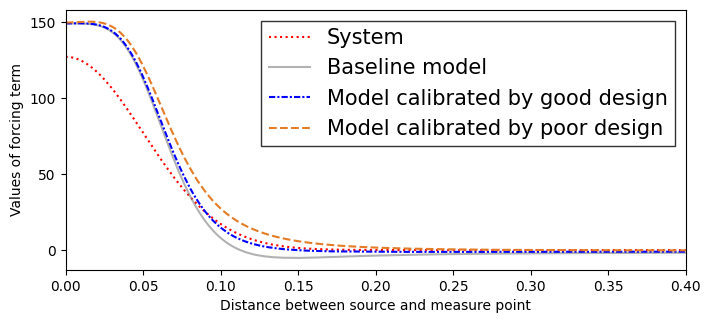

In [14]:
x = jnp.linspace(0, 0.3, size).reshape(-1, 1)
y = jnp.linspace(0, 0.3, size).reshape(-1, 1)  # Reshape y to match dimensions
xy_combined = jnp.concatenate((x, y), axis=1)  # Properly form (x, y) pairs
array_nn = model.apply(params0, xy_combined)
array_nn_5 = model.apply(params5, xy_combined)
array_nn_7 = model.apply(params7, xy_combined)

exponent_internal = ((x - 0.0) ** 2 + (y - 0.0) ** 2)
factor = 2.0 / (2.0 * jnp.pi * 0.05 ** 2)
array_exponent = factor * jnp.exp(-exponent_internal / (2.0 * 0.05 ** 2))
array_reciprocal = factor * 1.5 / (exponent_internal ** 2 / (2.0 * 0.05 ** 2) ** 2 + 1.0)
plt.figure(figsize=(8, 0.45*7.5))
# Directly use jnp arrays in plotting


plt.plot(jnp.sqrt(2) * x.squeeze(), 
         array_exponent.squeeze(), color = 'r', label='System',linestyle=':')#,alpha=0.6)
plt.plot(jnp.sqrt(2) * x.squeeze(), 
         (array_nn.squeeze() + array_reciprocal.squeeze()), 
         color = 'grey',label='Baseline model',linestyle='-',alpha=0.6)

plt.plot(jnp.sqrt(2) * x.squeeze(), 
         (array_nn_5.squeeze() + array_reciprocal.squeeze()), 
         label='Model calibrated by good design',color = 'b', linestyle=(0, (3, 1, 1, 1)))

plt.plot(jnp.sqrt(2) * x.squeeze(), 
         (array_nn_7.squeeze() + array_reciprocal.squeeze()), 
         label='Model calibrated by poor design',color = np.array([228,123,38])/255, linestyle='--')


plt.xlabel('Distance between source and measure point')
plt.ylabel('Values of forcing term')# of source/network')

plt.xlim([0,0.4])
#plt.yscale('log')
#plt.yscale('symlog', linthresh=1)

#plt.legend()
#intersection_x = 0.07
#plt.axvline(x=intersection_x, color='black', linestyle='--')
#plt.axvspan(0, intersection_x, color='lightgrey', alpha=0.5)

font_size = 15
plt.rcParams.update({'font.size': font_size})

legend = plt.legend(borderpad=0.05,loc='upper right', bbox_to_anchor=(0.99, 0.975),fontsize=font_size)

legend.get_frame().set_edgecolor('black')  
legend.get_frame().set_linewidth(1)  
legend.get_frame().set_boxstyle("Square")

#plt.savefig('combined network shape.png', dpi=600, bbox_inches='tight')
plt.show()

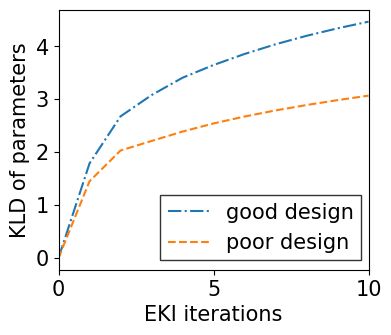

In [15]:
plt.figure(figsize=(4, 0.45*7.5))
plt.plot(kld_trajectory5, linestyle = '-.', label = 'good design')
plt.plot(kld_trajectory7, linestyle = '--', label = 'poor design')
plt.xlim([0,10])
plt.xticks([0,5,10])
plt.xlabel('EKI iterations')
plt.ylabel('KLD of parameters')
plt.legend()
legend = plt.legend(borderpad=0.05,loc='lower right', bbox_to_anchor=(0.99, 0.02),fontsize=font_size)

legend.get_frame().set_edgecolor('black') 
legend.get_frame().set_linewidth(1)  
legend.get_frame().set_boxstyle("Square")
#plt.savefig('KLD of parameter of NN case.png', dpi=600, bbox_inches='tight')
plt.show()

In [16]:
import matplotlib.patches as patches
stage = 2

u_t = sealed_convection_diffusion_true(d_start, center, stage)[1][100:151,100:151]
u_design_5 = sealed_convection_diffusion_nn(params5, d_start, center, stage, model)[1][100:151,100:151]
u_design_7 = sealed_convection_diffusion_nn(params7, d_start, center, stage, model)[1][100:151,100:151]
u_design_8 = sealed_convection_diffusion_nn(params_list[stage-1], d_start, center, stage, model)[1][100:151,100:151]

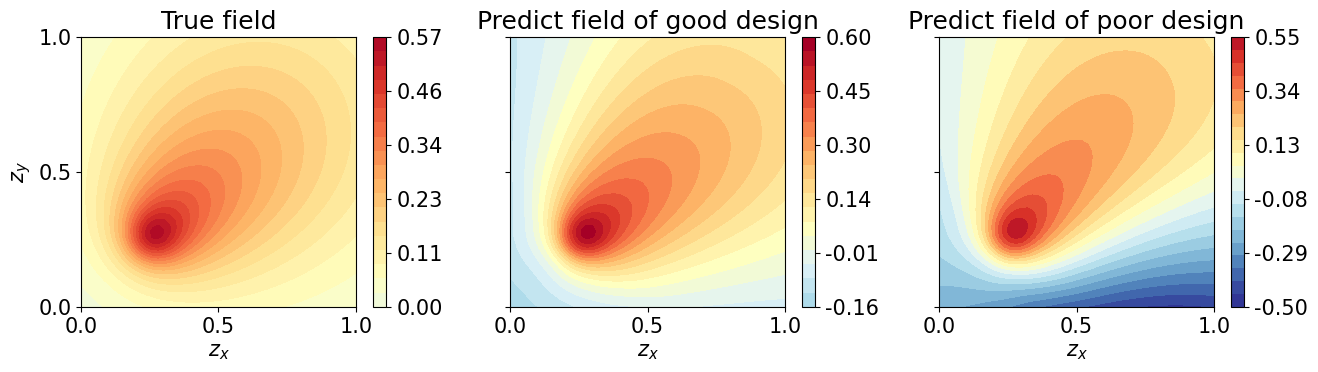

In [17]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15.5, 3.5))
plt.subplots_adjust(wspace=0.25)

vmin = min(np.min(u_t), np.min(u_design_5), np.min(u_design_7))
vmax = max(np.max(u_t), np.max(u_design_5), np.max(u_design_7))

# Plot contourf images with shared vmin and vmax
c1 = axes[0].contourf(np.linspace(0, 1, u_t.shape[0]), np.linspace(0, 1, u_t.shape[1]), u_t.T, vmin=vmin, vmax=vmax, levels=20, cmap='RdYlBu_r')
c2 = axes[1].contourf(np.linspace(0, 1, u_design_5.shape[0]), np.linspace(0, 1, u_design_5.shape[1]), u_design_5.T, vmin=vmin, vmax=vmax, levels=20, cmap='RdYlBu_r')
c3 = axes[2].contourf(np.linspace(0, 1, u_design_7.shape[0]), np.linspace(0, 1, u_design_7.shape[1]), u_design_7.T, vmin=vmin, vmax=vmax, levels=20, cmap='RdYlBu_r')#'YlGnBu_r'
# Create rectangles with normalized coordinates
axes[0].set_title('True field')

axes[1].set_title('Predict field of good design')

axes[2].set_title('Predict field of poor design')

# Set xlim and ylim for all axes

# Set xlim and ylim for all axes
for ax in axes:
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([0.0, 0.5,1.0])
    ax.set_xlabel('$z_x$')
    if ax == axes[0]:
        ax.set_yticks([0.0, 0.5,1.0])
        ax.set_ylabel('$z_y$')
    else:
        ax.set_yticks([0.0, 0.5,1.0])
        ax.set_yticklabels([])


for ax, c in zip(axes, [c1, c2, c3]):
    colorbar = fig.colorbar(c, ax=ax)
    
    vmin, vmax = colorbar.vmin, colorbar.vmax
    
    ticks = np.linspace(vmin, vmax, 6)
    
    colorbar.set_ticks(ticks)
    tick_labels = [f'{tick:.2f}' for tick in ticks]
    colorbar.set_ticklabels(tick_labels)

#plt.savefig('predict field with updated nn.png', dpi=600, bbox_inches='tight')
plt.show()

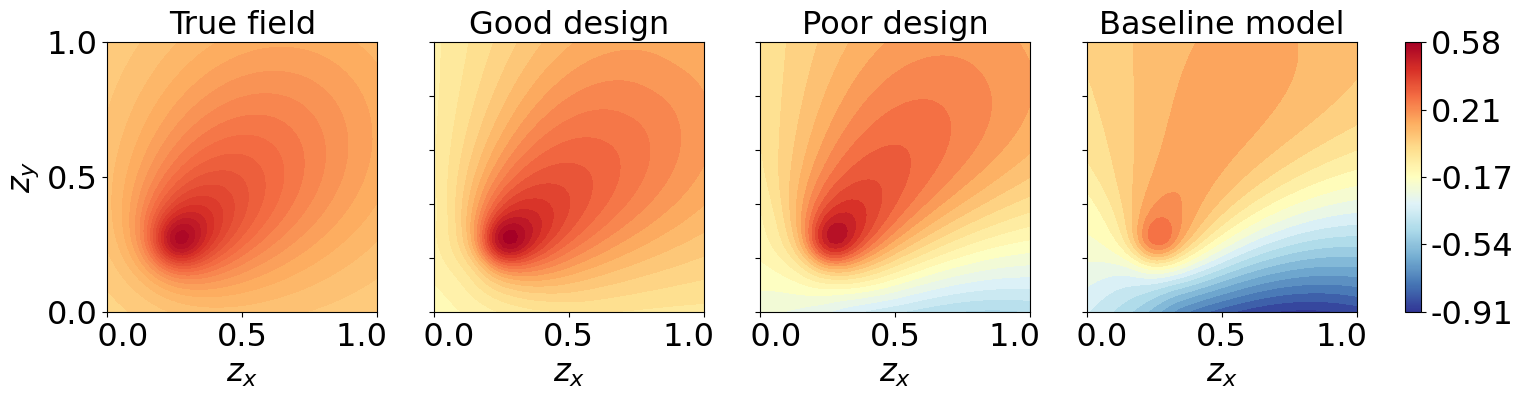

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

fig, axes = plt.subplots(1, 4, figsize=(4.03*4, 3.5))  
fig.subplots_adjust(wspace=0.21) 

vmin = min(np.min(u_t), np.min(u_design_5), np.min(u_design_7), np.min(u_design_8))
vmax = max(np.max(u_t), np.max(u_design_5), np.max(u_design_7), np.max(u_design_8))

fontsize = 23
cmap = 'RdYlBu_r' 

def custom_formatter(x, pos):
    if x == 0.0:
        return '   0.0' 
    elif x == 0.5:
        return '0.5'  
    elif x == 1.0:
        return '1.0   '
    else:
        return f'{x:.2f}'

c1 = axes[0].contourf(np.linspace(0, 1, u_t.shape[0]), np.linspace(0, 1, u_t.shape[1]), u_t.T, vmin=vmin, vmax=vmax, levels=20, cmap=cmap)
c2 = axes[1].contourf(np.linspace(0, 1, u_design_5.shape[0]), np.linspace(0, 1, u_design_5.shape[1]), u_design_5.T, vmin=vmin, vmax=vmax, levels=20, cmap=cmap)
c3 = axes[2].contourf(np.linspace(0, 1, u_design_7.shape[0]), np.linspace(0, 1, u_design_7.shape[1]), u_design_7.T, vmin=vmin, vmax=vmax, levels=20, cmap=cmap)
c4 = axes[3].contourf(np.linspace(0, 1, u_design_8.shape[0]), np.linspace(0, 1, u_design_8.shape[1]), u_design_8.T, vmin=vmin, vmax=vmax, levels=20, cmap=cmap)

axes[0].set_title('True field', fontsize=fontsize)
axes[1].set_title('Good design', fontsize=fontsize)
axes[2].set_title('Poor design', fontsize=fontsize)
axes[3].set_title('Baseline model', fontsize=fontsize)

for ax in axes:
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([0.0, 0.5, 1.0])
    ax.set_xlabel('$z_x$', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.xaxis.set_major_formatter(FuncFormatter(custom_formatter)) 
    if ax == axes[0]:
        ax.set_yticks([0.0, 0.5, 1.0])
        ax.set_ylabel('$z_y$', fontsize=fontsize)
        ax.tick_params(axis='y', labelsize=fontsize) 
    else:
        ax.set_yticklabels([])

cbar_ax = fig.add_axes([0.93, 0.11, 0.01, 0.77]) 
contour_set = plt.cm.ScalarMappable(cmap=cmap)
contour_set.set_array(u_design_8)
contour_set.set_clim(vmin, vmax)
ticks = np.linspace(vmin, vmax, 5)
cbar = fig.colorbar(contour_set, cax=cbar_ax, orientation='vertical')
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_ticks(ticks)
tick_labels = [f'{tick:.2f}' for tick in ticks]
cbar.set_ticklabels(tick_labels)

#plt.savefig('predict_field_with_updated_nn.png', dpi=600, bbox_inches='tight')
plt.show()


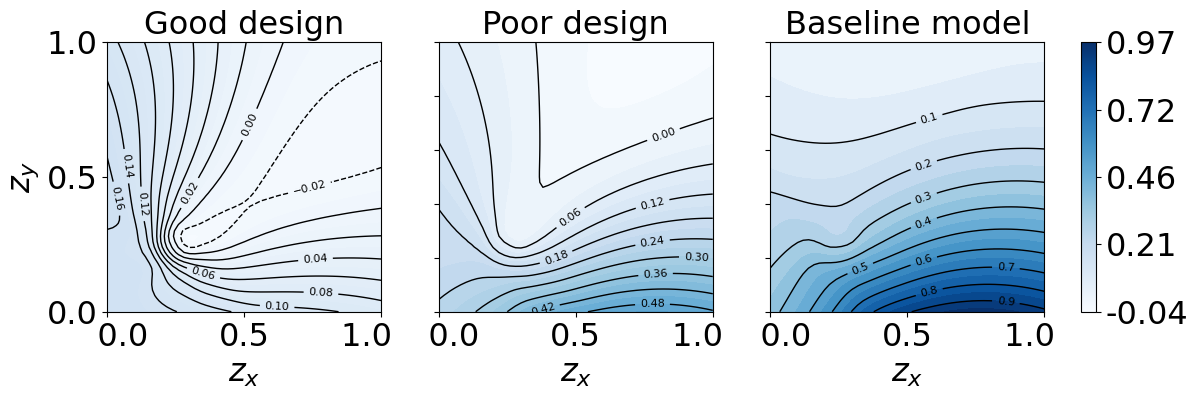

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(4.03*3, 3.5))  
fig.subplots_adjust(wspace=0.21)  

vmin = min(np.min(u_t - u_design_5), np.min(u_t - u_design_7), np.min(u_t - u_design_8))
vmax = max(np.max(u_t - u_design_5), np.max(u_t - u_design_7), np.max(u_t - u_design_8))

fontsize = 23
cmap = 'Blues' 

def custom_formatter(x, pos):
    if x == 0.0:
        return '   0.0' 
    elif x == 0.5:
        return '0.5'  
    elif x == 1.0:
        return '1.0   '
    else:
        return f'{x:.2f}'

c1 = axes[0].contourf(np.linspace(0, 1, u_t.shape[0]), np.linspace(0, 1, u_t.shape[1]), (u_t - u_design_5).T, vmin=vmin, vmax=vmax, levels=20, cmap=cmap)
c2 = axes[1].contourf(np.linspace(0, 1, u_t.shape[0]), np.linspace(0, 1, u_t.shape[1]), (u_t - u_design_7).T, vmin=vmin, vmax=vmax, levels=20, cmap=cmap)
c3 = axes[2].contourf(np.linspace(0, 1, u_t.shape[0]), np.linspace(0, 1, u_t.shape[1]), (u_t - u_design_8).T, vmin=vmin, vmax=vmax, levels=20, cmap=cmap)

contour1 = axes[0].contour(np.linspace(0, 1, u_t.shape[0]), np.linspace(0, 1, u_t.shape[1]), (u_t - u_design_5).T, levels=10, colors='black', linewidths=1)
contour2 = axes[1].contour(np.linspace(0, 1, u_t.shape[0]), np.linspace(0, 1, u_t.shape[1]), (u_t - u_design_7).T, levels=10, colors='black', linewidths=1)
contour3 = axes[2].contour(np.linspace(0, 1, u_t.shape[0]), np.linspace(0, 1, u_t.shape[1]), (u_t - u_design_8).T, levels=10, colors='black', linewidths=1)

axes[0].clabel(contour1, inline=True, fontsize=8)
axes[1].clabel(contour2, inline=True, fontsize=8)
axes[2].clabel(contour3, inline=True, fontsize=8)

axes[0].set_title('Good design', fontsize=fontsize)
axes[1].set_title('Poor design', fontsize=fontsize)
axes[2].set_title('Baseline model', fontsize=fontsize)

for ax in axes:
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([0.0, 0.5, 1.0])
    ax.set_xlabel('$z_x$', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.xaxis.set_major_formatter(FuncFormatter(custom_formatter)) 
    if ax == axes[0]:
        ax.set_yticks([0.0, 0.5, 1.0])
        ax.set_ylabel('$z_y$', fontsize=fontsize)
        ax.tick_params(axis='y', labelsize=fontsize)
    else:
        ax.set_yticklabels([])

cbar_ax = fig.add_axes([0.93, 0.11, 0.013, 0.77]) 
contour_set = plt.cm.ScalarMappable(cmap=cmap)
contour_set.set_array(u_design_8)
contour_set.set_clim(vmin, vmax)
ticks = np.linspace(vmin, vmax, 5)
cbar = fig.colorbar(contour_set, cax=cbar_ax, orientation='vertical')
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_ticks(ticks)
tick_labels = [f'{tick:.2f}' for tick in ticks]
cbar.set_ticklabels(tick_labels)


#plt.savefig('design_comparison.png', dpi=600, bbox_inches='tight')
plt.show()